# Fully-Connected Neural Nets
In the previous homework you implemented a fully-connected two-layer neural network on CIFAR-10. The implementation was simple but not very modular since the loss and gradient were computed in a single monolithic function. This is manageable for a simple two-layer network, but would become impractical as we move to bigger models. Ideally we want to build networks using a more modular design so that we can implement different layer types in isolation and then snap them together into models with different architectures.

In this exercise we will implement fully-connected networks using a more modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive dout (derivative of loss with respect to outputs) and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

In addition to implementing fully-connected networks of arbitrary depth, we will also explore different update rules for optimization, and introduce Dropout as a regularizer and Batch/Layer Normalization as a tool to more efficiently optimize deep networks.
  

In [1]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))
print ("setup done\n")

setup done



In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))
print ("done\n")

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))
done



# Affine layer: foward
Open the file `cs231n/layers.py` and implement the `affine_forward` function.

Once you are done you can test your implementaion by running the following:

In [3]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around e-9 or less.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.7698500479884e-10


# Affine layer: backward
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [4]:
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around e-10 or less
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))
print ("done here")

Testing affine_backward function:
dx error:  1.0908210113205496e-10
dw error:  2.273805557790167e-10
db error:  7.736978834487815e-12
done here


# ReLU activation: forward
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [5]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))
print ("done here")

Testing relu_forward function:
difference:  4.999999798022158e-08
done here


# ReLU activation: backward
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

In [6]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be on the order of e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print ("done here")

Testing relu_backward function:
dx error:  3.2756349136310288e-12
done here


## Inline Question 1: 

We've only asked you to implement ReLU, but there are a number of different activation functions that one could use in neural networks, each with its pros and cons. In particular, an issue commonly seen with activation functions is getting zero (or close to zero) gradient flow during backpropagation. Which of the following activation functions have this problem? If you consider these functions in the one dimensional case, what types of input would lead to this behaviour?
1. Sigmoid
2. ReLU
3. Leaky ReLU

## Answer:
Sigmoid, as the values have to be between 1 and 0, as values outside that range lead to dead activations and thus no learning at all, as sigmoids saturate and kill gradients. The predictions of this classifier are thus based on whether the output of the neuron is greater than 0.5. 


# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `cs231n/layer_utils.py`.

For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [7]:
from cs231n.layer_utils import affine_relu_forward, affine_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

# Relative error should be around e-10 or less
print('Testing affine_relu_forward and affine_relu_backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))
print ("done here")

Testing affine_relu_forward and affine_relu_backward:
dx error:  6.750573928879482e-11
dw error:  8.162015570444288e-11
db error:  7.826724021458994e-12
done here


# Loss layers: Softmax and SVM
You implemented these loss functions in the last assignment, so we'll give them to you for free here. You should still make sure you understand how they work by looking at the implementations in `cs231n/layers.py`.

You can make sure that the implementations are correct by running the following:

In [8]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be around the order of e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))
print ("done here")

Testing svm_loss:
loss:  8.999602749096233
dx error:  1.4021566006651672e-09

Testing softmax_loss:
loss:  2.302545844500738
dx error:  9.384673161989355e-09
done here


# Two-layer network
In the previous assignment you implemented a two-layer neural network in a single monolithic class. Now that you have implemented modular versions of the necessary layers, you will reimplement the two layer network using these modular implementations.

Open the file `cs231n/classifiers/fc_net.py` and complete the implementation of the `TwoLayerNet` class. This class will serve as a model for the other networks you will implement in this assignment, so read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [9]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'
print ("** gets here")
# Errors should be around e-7 or less
for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
print ("done here")

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
** gets here
Running numeric gradient check with reg =  0.0
W1 relative error: 1.52e-08
W2 relative error: 3.30e-10
b1 relative error: 8.37e-09
b2 relative error: 1.34e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 2.53e-07
W2 relative error: 2.85e-08
b1 relative error: 1.56e-08
b2 relative error: 9.09e-10
done here


# Solver
In the previous assignment, the logic for training models was coupled to the models themselves. Following a more modular design, for this assignment we have split the logic for training models into a separate class.

Open the file `cs231n/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves at least `50%` accuracy on the validation set.

In [10]:
model = TwoLayerNet()
solver = None

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################

model = TwoLayerNet(hidden_dim=100, reg=0.1)

solver = Solver(model, data, 
               update_rule='sgd',
               optim_config={
                   'learning_rate': 1.2e-3,
               },
               lr_decay=0.95,
               num_epochs=13, batch_size=200,
               print_every=1000)
solver.train()
print ("\n\n** done solving")

(Iteration 1 / 3185) loss: 2.315689
(Epoch 0 / 13) train acc: 0.166000; val_acc: 0.147000
(Epoch 1 / 13) train acc: 0.434000; val_acc: 0.427000
(Epoch 2 / 13) train acc: 0.470000; val_acc: 0.456000
(Epoch 3 / 13) train acc: 0.474000; val_acc: 0.477000
(Epoch 4 / 13) train acc: 0.528000; val_acc: 0.496000
(Iteration 1001 / 3185) loss: 1.491020
(Epoch 5 / 13) train acc: 0.527000; val_acc: 0.494000
(Epoch 6 / 13) train acc: 0.558000; val_acc: 0.507000
(Epoch 7 / 13) train acc: 0.560000; val_acc: 0.514000
(Epoch 8 / 13) train acc: 0.544000; val_acc: 0.497000
(Iteration 2001 / 3185) loss: 1.297155
(Epoch 9 / 13) train acc: 0.587000; val_acc: 0.516000
(Epoch 10 / 13) train acc: 0.575000; val_acc: 0.486000
(Epoch 11 / 13) train acc: 0.621000; val_acc: 0.536000
(Epoch 12 / 13) train acc: 0.645000; val_acc: 0.537000
(Iteration 3001 / 3185) loss: 1.141904
(Epoch 13 / 13) train acc: 0.617000; val_acc: 0.530000


** done solving


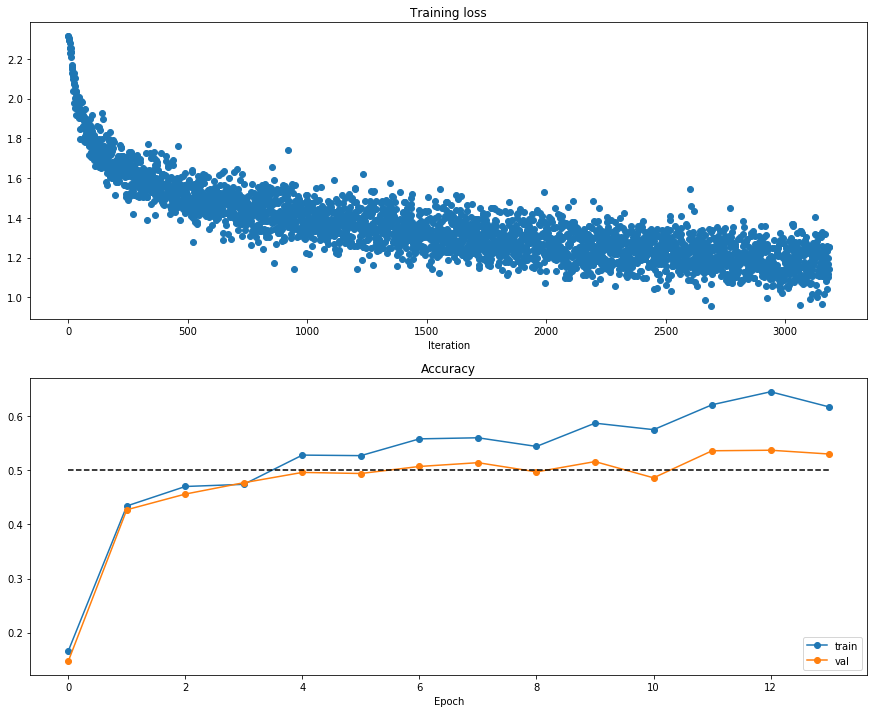

In [11]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Multilayer network
Next you will implement a fully-connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in the file `cs231n/classifiers/fc_net.py`.

Implement the initialization, the forward pass, and the backward pass. For the moment don't worry about implementing dropout or batch/layer normalization; we will add those features soon.

## Initial loss and gradient check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. Do the initial losses seem reasonable?

For gradient checking, you should expect to see errors around 1e-7 or less.

In [12]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,reg=reg, weight_scale=5e-2, dtype=np.float64)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)
  
  # Most of the errors should be on the order of e-7 or smaller.   
  # NOTE: It is fine however to see an error for W2 on the order of e-5
  # for the check when reg = 0.0
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
print ("done here")

Running check with reg =  0
Initial loss:  2.3004790897684924
W1 relative error: 1.48e-07
W2 relative error: 2.21e-05
W3 relative error: 3.53e-07
b1 relative error: 5.38e-09
b2 relative error: 2.09e-09
b3 relative error: 5.80e-11
Running check with reg =  3.14
Initial loss:  7.052114776533016
W1 relative error: 7.36e-09
W2 relative error: 6.87e-08
W3 relative error: 3.48e-08
b1 relative error: 1.48e-08
b2 relative error: 1.72e-09
b3 relative error: 1.80e-10
done here


As another sanity check, make sure you can overfit a small dataset of 50 images. First we will try a three-layer network with 100 units in each hidden layer. In the following cell, tweak the learning rate and initialization scale to overfit and achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 44.720838
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.120000
(Epoch 1 / 20) train acc: 0.300000; val_acc: 0.135000
(Epoch 2 / 20) train acc: 0.460000; val_acc: 0.145000
(Epoch 3 / 20) train acc: 0.700000; val_acc: 0.149000
(Epoch 4 / 20) train acc: 0.740000; val_acc: 0.157000
(Epoch 5 / 20) train acc: 0.880000; val_acc: 0.171000
(Iteration 11 / 40) loss: 0.201521
(Epoch 6 / 20) train acc: 0.880000; val_acc: 0.172000
(Epoch 7 / 20) train acc: 0.920000; val_acc: 0.168000
(Epoch 8 / 20) train acc: 0.980000; val_acc: 0.168000
(Epoch 9 / 20) train acc: 0.980000; val_acc: 0.168000
(Epoch 10 / 20) train acc: 0.980000; val_acc: 0.169000
(Iteration 21 / 40) loss: 0.677759
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.161000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.161000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.160000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.160000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.161000
(Iteration 31 / 40) loss:

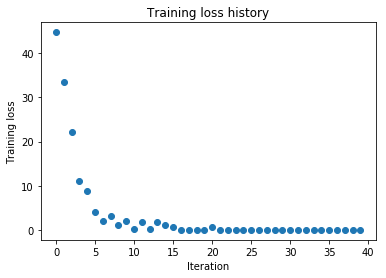

In [13]:
# TODO: Use a three-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 5e-2
learning_rate = 1e-3
model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()
print ("\n** done solving")

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Again you will have to adjust the learning rate and weight initialization, but you should be able to achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 618.192096
(Epoch 0 / 20) train acc: 0.220000; val_acc: 0.115000
(Epoch 1 / 20) train acc: 0.220000; val_acc: 0.087000
(Epoch 2 / 20) train acc: 0.240000; val_acc: 0.148000
(Epoch 3 / 20) train acc: 0.540000; val_acc: 0.123000
(Epoch 4 / 20) train acc: 0.660000; val_acc: 0.125000
(Epoch 5 / 20) train acc: 0.780000; val_acc: 0.124000
(Iteration 11 / 40) loss: 26.675944
(Epoch 6 / 20) train acc: 0.860000; val_acc: 0.127000
(Epoch 7 / 20) train acc: 0.860000; val_acc: 0.122000
(Epoch 8 / 20) train acc: 0.880000; val_acc: 0.121000
(Epoch 9 / 20) train acc: 0.960000; val_acc: 0.125000
(Epoch 10 / 20) train acc: 0.940000; val_acc: 0.121000
(Iteration 21 / 40) loss: 4.105570
(Epoch 11 / 20) train acc: 0.960000; val_acc: 0.128000
(Epoch 12 / 20) train acc: 0.980000; val_acc: 0.129000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.130000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.131000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.131000
(Iteration 31 / 40) los

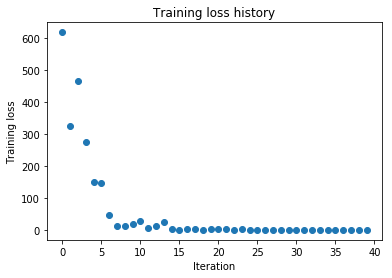

In [14]:
# TODO: Use a five-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

learning_rate = 2e-4
weight_scale = 1.3e-1
model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

## Inline Question 2: 
Did you notice anything about the comparative difficulty of training the three-layer net vs training the five layer net? In particular, based on your experience, which network seemed more sensitive to the initialization scale? Why do you think that is the case?

## Answer:
The 5 layer network seems harder to train as it is more sensitive to the hyperparameters of learning rate and weight scale. The deeper model is more responsive to changes compared to the 3 layer network. 


# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

# SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochastic gradient descent. See the Momentum Update section at http://cs231n.github.io/neural-networks-3/#sgd for more information.

Open the file `cs231n/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than e-8.

In [15]:
from cs231n.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

# Should see relative errors around e-8 or less
print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

running with  sgd
(Iteration 1 / 200) loss: 2.559978
(Epoch 0 / 5) train acc: 0.103000; val_acc: 0.108000
(Iteration 11 / 200) loss: 2.291086
(Iteration 21 / 200) loss: 2.153591
(Iteration 31 / 200) loss: 2.082693
(Epoch 1 / 5) train acc: 0.277000; val_acc: 0.242000
(Iteration 41 / 200) loss: 2.004171
(Iteration 51 / 200) loss: 2.010409
(Iteration 61 / 200) loss: 2.022463
(Iteration 71 / 200) loss: 2.029975
(Epoch 2 / 5) train acc: 0.353000; val_acc: 0.312000
(Iteration 81 / 200) loss: 1.805454
(Iteration 91 / 200) loss: 1.911051
(Iteration 101 / 200) loss: 1.914574
(Iteration 111 / 200) loss: 1.706396
(Epoch 3 / 5) train acc: 0.409000; val_acc: 0.327000
(Iteration 121 / 200) loss: 1.706038
(Iteration 131 / 200) loss: 1.779879
(Iteration 141 / 200) loss: 1.798783
(Iteration 151 / 200) loss: 1.819628
(Epoch 4 / 5) train acc: 0.425000; val_acc: 0.324000
(Iteration 161 / 200) loss: 1.624850
(Iteration 171 / 200) loss: 1.888062
(Iteration 181 / 200) loss: 1.540264
(Iteration 191 / 200) los

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


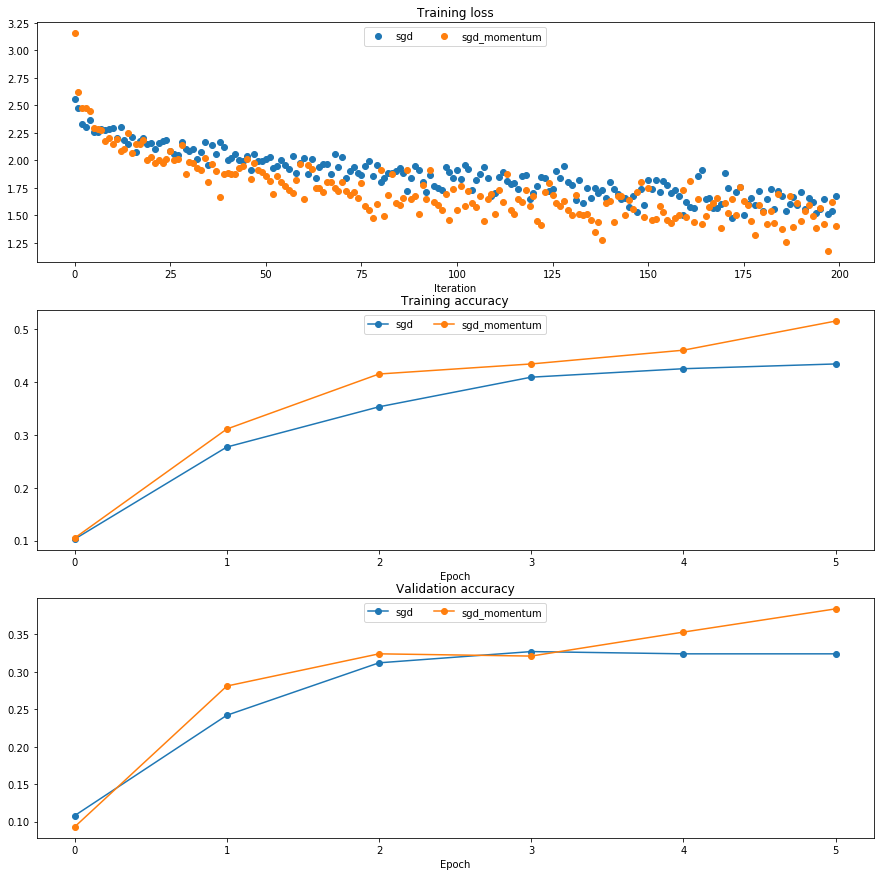

In [16]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 1e-2,
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# RMSProp and Adam
RMSProp [1] and Adam [2] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

In the file `cs231n/optim.py`, implement the RMSProp update rule in the `rmsprop` function and implement the Adam update rule in the `adam` function, and check your implementations using the tests below.

**NOTE:** Please implement the _complete_ Adam update rule (with the bias correction mechanism), not the first simplified version mentioned in the course notes. 

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [17]:
# Test RMSProp implementation
from cs231n.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.524687511038133e-08
cache error:  2.6477955807156126e-09


In [27]:
# Test Adam implementation
from cs231n.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))
print ("done here")

next_w error:  1.1395691798535431e-07
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09
done here


Once you have debugged your RMSProp and Adam implementations, run the following to train a pair of deep networks using these new update rules:

running with  adam
(Iteration 1 / 200) loss: 3.476928
(Epoch 0 / 5) train acc: 0.126000; val_acc: 0.110000
(Iteration 11 / 200) loss: 2.027712
(Iteration 21 / 200) loss: 2.183358
(Iteration 31 / 200) loss: 1.744257
(Epoch 1 / 5) train acc: 0.363000; val_acc: 0.330000
(Iteration 41 / 200) loss: 1.707951
(Iteration 51 / 200) loss: 1.703835
(Iteration 61 / 200) loss: 2.094758
(Iteration 71 / 200) loss: 1.505558
(Epoch 2 / 5) train acc: 0.419000; val_acc: 0.362000
(Iteration 81 / 200) loss: 1.594429
(Iteration 91 / 200) loss: 1.519017
(Iteration 101 / 200) loss: 1.368522
(Iteration 111 / 200) loss: 1.470400
(Epoch 3 / 5) train acc: 0.460000; val_acc: 0.378000
(Iteration 121 / 200) loss: 1.199064
(Iteration 131 / 200) loss: 1.464705
(Iteration 141 / 200) loss: 1.359863
(Iteration 151 / 200) loss: 1.415069
(Epoch 4 / 5) train acc: 0.521000; val_acc: 0.374000
(Iteration 161 / 200) loss: 1.382818
(Iteration 171 / 200) loss: 1.359900
(Iteration 181 / 200) loss: 1.095947
(Iteration 191 / 200) lo

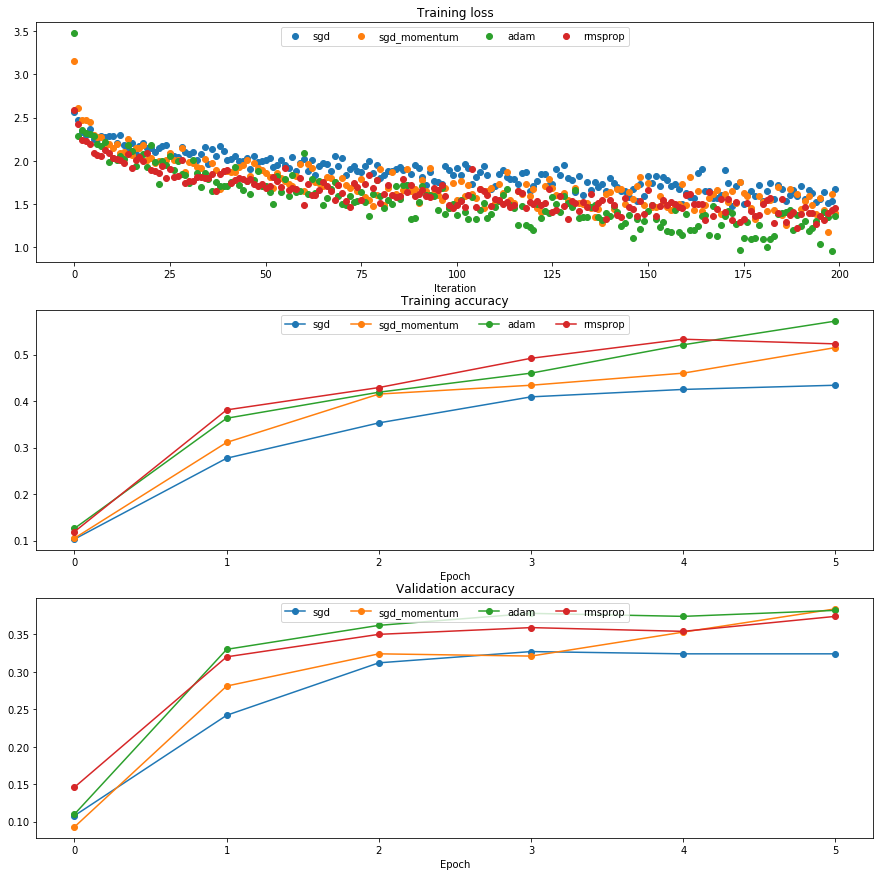

In [18]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule]
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

## Inline Question 3:

AdaGrad, like Adam, is a per-parameter optimization method that uses the following update rule:

```
cache += dw**2
w += - learning_rate * dw / (np.sqrt(cache) + eps)
```

John notices that when he was training a network with AdaGrad that the updates became very small, and that his network was learning slowly. Using your knowledge of the AdaGrad update rule, why do you think the updates would become very small? Would Adam have the same issue?


## Answer: 
Because cache is a sum of dw square values, as the learning progresses, this value will become larger and larger, and in the process of w update, it needs to be divided by cache, which will cause the actual learnig rate to become smaller and smaller. The greadient thus becomes inversely propotional to the update of the weights, slowing down the learning/update of learnable parameters. 

# Train a good model!
Train the best fully-connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 50% accuracy on the validation set using a fully-connected net.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. Later in the assignment we will ask you to train the best convolutional network that you can on CIFAR-10, and we would prefer that you spend your effort working on convolutional nets rather than fully-connected nets.

You might find it useful to complete the `BatchNormalization.ipynb` and `Dropout.ipynb` notebooks before completing this part, since those techniques can help you train powerful models.

In [20]:
best_model = None

################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# find batch/layer normalization and dropout useful. Store your best model in  #
# the best_model variable.                                                     #
################################################################################

best_val_acc = -1

# hyperparameters
learning_rate = [1e-3,3e-3,1e-2]
weight_scale = [1e-3,3e-3,1e-2]
dropouts= [0.25,0.5,0.9]

print ("starting optimization")
# this took wayyyy way too long to train, maybe comment out dropouts (recommended)
for lr in learning_rate:
    for ws in weight_scale:
        for drop in dropouts:
            # I use arbitrary model architecture to optimize (4 layer net),200
            model = FullyConnectedNet([200,100,50, 20, 15],dropout=drop,
                            weight_scale=ws, dtype=np.float64)
            solver = Solver(model, data,
                            print_every=50, num_epochs=20, batch_size=200,
                            update_rule='adam',
                            optim_config={
                              'learning_rate': lr,
                            }
                     )
            solver.train()
            if solver.best_val_acc>best_val_acc:
                best_val_acc=solver.best_val_acc
                best_model=solver

print ("\n\n** done optimizing\nAnalytics\n")

starting optimization
(Iteration 1 / 4900) loss: 2.302585
(Epoch 0 / 20) train acc: 0.112000; val_acc: 0.078000
(Iteration 51 / 4900) loss: 2.303117
(Iteration 101 / 4900) loss: 2.245594
(Iteration 151 / 4900) loss: 2.249554
(Iteration 201 / 4900) loss: 2.208447
(Epoch 1 / 20) train acc: 0.150000; val_acc: 0.179000
(Iteration 251 / 4900) loss: 2.263753
(Iteration 301 / 4900) loss: 2.324091
(Iteration 351 / 4900) loss: 2.252775
(Iteration 401 / 4900) loss: 2.202626
(Iteration 451 / 4900) loss: 2.248512
(Epoch 2 / 20) train acc: 0.146000; val_acc: 0.139000
(Iteration 501 / 4900) loss: 2.208809
(Iteration 551 / 4900) loss: 2.187536
(Iteration 601 / 4900) loss: 2.219851
(Iteration 651 / 4900) loss: 2.218605
(Iteration 701 / 4900) loss: 2.213268
(Epoch 3 / 20) train acc: 0.128000; val_acc: 0.131000
(Iteration 751 / 4900) loss: 2.246206
(Iteration 801 / 4900) loss: 2.209241
(Iteration 851 / 4900) loss: 2.161291
(Iteration 901 / 4900) loss: 2.191561
(Iteration 951 / 4900) loss: 2.258564
(Epoc

(Iteration 3201 / 4900) loss: 1.999664
(Iteration 3251 / 4900) loss: 2.062800
(Iteration 3301 / 4900) loss: 1.985892
(Iteration 3351 / 4900) loss: 2.007496
(Iteration 3401 / 4900) loss: 2.048280
(Epoch 14 / 20) train acc: 0.201000; val_acc: 0.202000
(Iteration 3451 / 4900) loss: 1.981601
(Iteration 3501 / 4900) loss: 2.038906
(Iteration 3551 / 4900) loss: 2.046210
(Iteration 3601 / 4900) loss: 1.993069
(Iteration 3651 / 4900) loss: 2.031793
(Epoch 15 / 20) train acc: 0.196000; val_acc: 0.192000
(Iteration 3701 / 4900) loss: 2.020729
(Iteration 3751 / 4900) loss: 2.027982
(Iteration 3801 / 4900) loss: 1.990674
(Iteration 3851 / 4900) loss: 2.007859
(Iteration 3901 / 4900) loss: 2.015248
(Epoch 16 / 20) train acc: 0.230000; val_acc: 0.225000
(Iteration 3951 / 4900) loss: 2.094394
(Iteration 4001 / 4900) loss: 2.008204
(Iteration 4051 / 4900) loss: 2.119886
(Iteration 4101 / 4900) loss: 2.056688
(Iteration 4151 / 4900) loss: 2.054353
(Epoch 17 / 20) train acc: 0.221000; val_acc: 0.217000


(Iteration 1551 / 4900) loss: 2.169388
(Iteration 1601 / 4900) loss: 2.132005
(Iteration 1651 / 4900) loss: 2.181234
(Iteration 1701 / 4900) loss: 2.111493
(Epoch 7 / 20) train acc: 0.094000; val_acc: 0.107000
(Iteration 1751 / 4900) loss: 2.191740
(Iteration 1801 / 4900) loss: 2.231823
(Iteration 1851 / 4900) loss: 2.155173
(Iteration 1901 / 4900) loss: 2.242211
(Iteration 1951 / 4900) loss: 2.186033
(Epoch 8 / 20) train acc: 0.132000; val_acc: 0.136000
(Iteration 2001 / 4900) loss: 2.218127
(Iteration 2051 / 4900) loss: 2.150835
(Iteration 2101 / 4900) loss: 2.186841
(Iteration 2151 / 4900) loss: 2.168119
(Iteration 2201 / 4900) loss: 2.211963
(Epoch 9 / 20) train acc: 0.115000; val_acc: 0.128000
(Iteration 2251 / 4900) loss: 2.138501
(Iteration 2301 / 4900) loss: 2.127262
(Iteration 2351 / 4900) loss: 2.203386
(Iteration 2401 / 4900) loss: 2.265452
(Epoch 10 / 20) train acc: 0.141000; val_acc: 0.140000
(Iteration 2451 / 4900) loss: 2.166310
(Iteration 2501 / 4900) loss: 2.201990
(It

(Iteration 4851 / 4900) loss: 1.956635
(Epoch 20 / 20) train acc: 0.319000; val_acc: 0.295000
(Iteration 1 / 4900) loss: 2.302585
(Epoch 0 / 20) train acc: 0.108000; val_acc: 0.079000
(Iteration 51 / 4900) loss: 2.159292
(Iteration 101 / 4900) loss: 2.034729
(Iteration 151 / 4900) loss: 2.048496
(Iteration 201 / 4900) loss: 1.982985
(Epoch 1 / 20) train acc: 0.191000; val_acc: 0.204000
(Iteration 251 / 4900) loss: 2.091993
(Iteration 301 / 4900) loss: 2.019266
(Iteration 351 / 4900) loss: 2.065067
(Iteration 401 / 4900) loss: 2.016160
(Iteration 451 / 4900) loss: 1.969693
(Epoch 2 / 20) train acc: 0.198000; val_acc: 0.220000
(Iteration 501 / 4900) loss: 1.998670
(Iteration 551 / 4900) loss: 1.888278
(Iteration 601 / 4900) loss: 1.896736
(Iteration 651 / 4900) loss: 1.981518
(Iteration 701 / 4900) loss: 1.811726
(Epoch 3 / 20) train acc: 0.277000; val_acc: 0.304000
(Iteration 751 / 4900) loss: 1.817964
(Iteration 801 / 4900) loss: 1.837642
(Iteration 851 / 4900) loss: 1.875461
(Iteratio

(Epoch 13 / 20) train acc: 0.201000; val_acc: 0.210000
(Iteration 3201 / 4900) loss: 2.200172
(Iteration 3251 / 4900) loss: 2.135102
(Iteration 3301 / 4900) loss: 2.205968
(Iteration 3351 / 4900) loss: 2.120074
(Iteration 3401 / 4900) loss: 2.156445
(Epoch 14 / 20) train acc: 0.195000; val_acc: 0.199000
(Iteration 3451 / 4900) loss: 2.183684
(Iteration 3501 / 4900) loss: 2.143909
(Iteration 3551 / 4900) loss: 2.182241
(Iteration 3601 / 4900) loss: 2.124682
(Iteration 3651 / 4900) loss: 2.157599
(Epoch 15 / 20) train acc: 0.160000; val_acc: 0.164000
(Iteration 3701 / 4900) loss: 2.212905
(Iteration 3751 / 4900) loss: 2.186211
(Iteration 3801 / 4900) loss: 2.157066
(Iteration 3851 / 4900) loss: 2.164046
(Iteration 3901 / 4900) loss: 2.186095
(Epoch 16 / 20) train acc: 0.191000; val_acc: 0.206000
(Iteration 3951 / 4900) loss: 2.208654
(Iteration 4001 / 4900) loss: 2.200199
(Iteration 4051 / 4900) loss: 2.149535
(Iteration 4101 / 4900) loss: 2.153362
(Iteration 4151 / 4900) loss: 2.152631


(Iteration 1501 / 4900) loss: 1.418474
(Iteration 1551 / 4900) loss: 1.409566
(Iteration 1601 / 4900) loss: 1.613358
(Iteration 1651 / 4900) loss: 1.463672
(Iteration 1701 / 4900) loss: 1.428266
(Epoch 7 / 20) train acc: 0.488000; val_acc: 0.471000
(Iteration 1751 / 4900) loss: 1.475065
(Iteration 1801 / 4900) loss: 1.490553
(Iteration 1851 / 4900) loss: 1.633072
(Iteration 1901 / 4900) loss: 1.529525
(Iteration 1951 / 4900) loss: 1.509333
(Epoch 8 / 20) train acc: 0.509000; val_acc: 0.474000
(Iteration 2001 / 4900) loss: 1.371610
(Iteration 2051 / 4900) loss: 1.573505
(Iteration 2101 / 4900) loss: 1.465756
(Iteration 2151 / 4900) loss: 1.417879
(Iteration 2201 / 4900) loss: 1.418827
(Epoch 9 / 20) train acc: 0.531000; val_acc: 0.463000
(Iteration 2251 / 4900) loss: 1.368562
(Iteration 2301 / 4900) loss: 1.391517
(Iteration 2351 / 4900) loss: 1.423386
(Iteration 2401 / 4900) loss: 1.429812
(Epoch 10 / 20) train acc: 0.543000; val_acc: 0.484000
(Iteration 2451 / 4900) loss: 1.420551
(It

(Iteration 4801 / 4900) loss: 2.302073
(Iteration 4851 / 4900) loss: 2.303709
(Epoch 20 / 20) train acc: 0.093000; val_acc: 0.102000
(Iteration 1 / 4900) loss: 2.302585
(Epoch 0 / 20) train acc: 0.096000; val_acc: 0.119000
(Iteration 51 / 4900) loss: 2.278999
(Iteration 101 / 4900) loss: 2.189539
(Iteration 151 / 4900) loss: 2.261396
(Iteration 201 / 4900) loss: 2.139487
(Epoch 1 / 20) train acc: 0.191000; val_acc: 0.172000
(Iteration 251 / 4900) loss: 2.129528
(Iteration 301 / 4900) loss: 2.114710
(Iteration 351 / 4900) loss: 2.079669
(Iteration 401 / 4900) loss: 2.128440
(Iteration 451 / 4900) loss: 2.130988
(Epoch 2 / 20) train acc: 0.172000; val_acc: 0.190000
(Iteration 501 / 4900) loss: 2.206866
(Iteration 551 / 4900) loss: 2.164826
(Iteration 601 / 4900) loss: 2.203226
(Iteration 651 / 4900) loss: 2.115156
(Iteration 701 / 4900) loss: 2.148354
(Epoch 3 / 20) train acc: 0.185000; val_acc: 0.202000
(Iteration 751 / 4900) loss: 2.100615
(Iteration 801 / 4900) loss: 2.187691
(Iterati

(Iteration 3151 / 4900) loss: 2.303388
(Epoch 13 / 20) train acc: 0.121000; val_acc: 0.119000
(Iteration 3201 / 4900) loss: 2.302300
(Iteration 3251 / 4900) loss: 2.302842
(Iteration 3301 / 4900) loss: 2.300543
(Iteration 3351 / 4900) loss: 2.302299
(Iteration 3401 / 4900) loss: 2.302647
(Epoch 14 / 20) train acc: 0.103000; val_acc: 0.098000
(Iteration 3451 / 4900) loss: 2.303308
(Iteration 3501 / 4900) loss: 2.302601
(Iteration 3551 / 4900) loss: 2.304891
(Iteration 3601 / 4900) loss: 2.305152
(Iteration 3651 / 4900) loss: 2.301558
(Epoch 15 / 20) train acc: 0.098000; val_acc: 0.112000
(Iteration 3701 / 4900) loss: 2.302121
(Iteration 3751 / 4900) loss: 2.302510
(Iteration 3801 / 4900) loss: 2.301113
(Iteration 3851 / 4900) loss: 2.300031
(Iteration 3901 / 4900) loss: 2.303611
(Epoch 16 / 20) train acc: 0.082000; val_acc: 0.113000
(Iteration 3951 / 4900) loss: 2.302695
(Iteration 4001 / 4900) loss: 2.302089
(Iteration 4051 / 4900) loss: 2.303811
(Iteration 4101 / 4900) loss: 2.302243


(Epoch 6 / 20) train acc: 0.153000; val_acc: 0.167000
(Iteration 1501 / 4900) loss: 2.202482
(Iteration 1551 / 4900) loss: 2.145705
(Iteration 1601 / 4900) loss: 2.231830
(Iteration 1651 / 4900) loss: 2.211624
(Iteration 1701 / 4900) loss: 2.184371
(Epoch 7 / 20) train acc: 0.179000; val_acc: 0.200000
(Iteration 1751 / 4900) loss: 2.193930
(Iteration 1801 / 4900) loss: 2.209535
(Iteration 1851 / 4900) loss: 2.208083
(Iteration 1901 / 4900) loss: 2.166558
(Iteration 1951 / 4900) loss: 2.130517
(Epoch 8 / 20) train acc: 0.156000; val_acc: 0.190000
(Iteration 2001 / 4900) loss: 2.142782
(Iteration 2051 / 4900) loss: 2.184908
(Iteration 2101 / 4900) loss: 2.216477
(Iteration 2151 / 4900) loss: 2.178680
(Iteration 2201 / 4900) loss: 2.257351
(Epoch 9 / 20) train acc: 0.178000; val_acc: 0.184000
(Iteration 2251 / 4900) loss: 2.261666
(Iteration 2301 / 4900) loss: 2.218446
(Iteration 2351 / 4900) loss: 2.278213
(Iteration 2401 / 4900) loss: 2.252195
(Epoch 10 / 20) train acc: 0.159000; val_ac

(Iteration 4701 / 4900) loss: 1.954337
(Iteration 4751 / 4900) loss: 1.932798
(Iteration 4801 / 4900) loss: 2.000224
(Iteration 4851 / 4900) loss: 2.042113
(Epoch 20 / 20) train acc: 0.285000; val_acc: 0.284000
(Iteration 1 / 4900) loss: 2.302590
(Epoch 0 / 20) train acc: 0.122000; val_acc: 0.078000
(Iteration 51 / 4900) loss: 2.306340
(Iteration 101 / 4900) loss: 2.306217
(Iteration 151 / 4900) loss: 2.303146
(Iteration 201 / 4900) loss: 2.304401
(Epoch 1 / 20) train acc: 0.087000; val_acc: 0.098000
(Iteration 251 / 4900) loss: 2.304353
(Iteration 301 / 4900) loss: 2.300707
(Iteration 351 / 4900) loss: 2.302350
(Iteration 401 / 4900) loss: 2.304093
(Iteration 451 / 4900) loss: 2.302820
(Epoch 2 / 20) train acc: 0.080000; val_acc: 0.105000
(Iteration 501 / 4900) loss: 2.301807
(Iteration 551 / 4900) loss: 2.303244
(Iteration 601 / 4900) loss: 2.303090
(Iteration 651 / 4900) loss: 2.302149
(Iteration 701 / 4900) loss: 2.302385
(Epoch 3 / 20) train acc: 0.098000; val_acc: 0.079000
(Itera

(Iteration 3051 / 4900) loss: 2.307529
(Iteration 3101 / 4900) loss: 2.237670
(Iteration 3151 / 4900) loss: 2.232043
(Epoch 13 / 20) train acc: 0.144000; val_acc: 0.172000
(Iteration 3201 / 4900) loss: 2.191127
(Iteration 3251 / 4900) loss: 2.218047
(Iteration 3301 / 4900) loss: 2.239223
(Iteration 3351 / 4900) loss: 2.223967
(Iteration 3401 / 4900) loss: 2.221532
(Epoch 14 / 20) train acc: 0.149000; val_acc: 0.146000
(Iteration 3451 / 4900) loss: 2.255971
(Iteration 3501 / 4900) loss: 2.281023
(Iteration 3551 / 4900) loss: 2.238732
(Iteration 3601 / 4900) loss: 2.217434
(Iteration 3651 / 4900) loss: 2.263950
(Epoch 15 / 20) train acc: 0.150000; val_acc: 0.163000
(Iteration 3701 / 4900) loss: 2.187964
(Iteration 3751 / 4900) loss: 2.249276
(Iteration 3801 / 4900) loss: 2.222264
(Iteration 3851 / 4900) loss: 2.220846
(Iteration 3901 / 4900) loss: 2.290108
(Epoch 16 / 20) train acc: 0.160000; val_acc: 0.164000
(Iteration 3951 / 4900) loss: 2.282377
(Iteration 4001 / 4900) loss: 2.239662


(Iteration 1401 / 4900) loss: 2.306332
(Iteration 1451 / 4900) loss: 2.302296
(Epoch 6 / 20) train acc: 0.106000; val_acc: 0.105000
(Iteration 1501 / 4900) loss: 2.306403
(Iteration 1551 / 4900) loss: 2.306337
(Iteration 1601 / 4900) loss: 2.305978
(Iteration 1651 / 4900) loss: 2.302550
(Iteration 1701 / 4900) loss: 2.298651
(Epoch 7 / 20) train acc: 0.086000; val_acc: 0.105000
(Iteration 1751 / 4900) loss: 2.302333
(Iteration 1801 / 4900) loss: 2.307629
(Iteration 1851 / 4900) loss: 2.300390
(Iteration 1901 / 4900) loss: 2.304959
(Iteration 1951 / 4900) loss: 2.299449
(Epoch 8 / 20) train acc: 0.106000; val_acc: 0.087000
(Iteration 2001 / 4900) loss: 2.301081
(Iteration 2051 / 4900) loss: 2.301919
(Iteration 2101 / 4900) loss: 2.301649
(Iteration 2151 / 4900) loss: 2.303662
(Iteration 2201 / 4900) loss: 2.304766
(Epoch 9 / 20) train acc: 0.096000; val_acc: 0.105000
(Iteration 2251 / 4900) loss: 2.301533
(Iteration 2301 / 4900) loss: 2.303605
(Iteration 2351 / 4900) loss: 2.302509
(Ite

(Epoch 19 / 20) train acc: 0.103000; val_acc: 0.119000
(Iteration 4701 / 4900) loss: 2.301127
(Iteration 4751 / 4900) loss: 2.299431
(Iteration 4801 / 4900) loss: 2.303566
(Iteration 4851 / 4900) loss: 2.303340
(Epoch 20 / 20) train acc: 0.101000; val_acc: 0.087000
(Iteration 1 / 4900) loss: 2.302585
(Epoch 0 / 20) train acc: 0.114000; val_acc: 0.087000
(Iteration 51 / 4900) loss: 2.201545
(Iteration 101 / 4900) loss: 2.186845
(Iteration 151 / 4900) loss: 2.071647
(Iteration 201 / 4900) loss: 2.146328
(Epoch 1 / 20) train acc: 0.204000; val_acc: 0.209000
(Iteration 251 / 4900) loss: 2.198876
(Iteration 301 / 4900) loss: 2.107826
(Iteration 351 / 4900) loss: 2.245906
(Iteration 401 / 4900) loss: 2.262746
(Iteration 451 / 4900) loss: 2.264832
(Epoch 2 / 20) train acc: 0.152000; val_acc: 0.158000
(Iteration 501 / 4900) loss: 2.276758
(Iteration 551 / 4900) loss: 2.239023
(Iteration 601 / 4900) loss: 2.212178
(Iteration 651 / 4900) loss: 2.248496
(Iteration 701 / 4900) loss: 2.223270
(Epoc

(Iteration 2951 / 4900) loss: 2.299710
(Iteration 3001 / 4900) loss: 2.304548
(Iteration 3051 / 4900) loss: 2.301560
(Iteration 3101 / 4900) loss: 2.302760
(Iteration 3151 / 4900) loss: 2.303232
(Epoch 13 / 20) train acc: 0.106000; val_acc: 0.078000
(Iteration 3201 / 4900) loss: 2.300613
(Iteration 3251 / 4900) loss: 2.301474
(Iteration 3301 / 4900) loss: 2.304110
(Iteration 3351 / 4900) loss: 2.305713
(Iteration 3401 / 4900) loss: 2.302271
(Epoch 14 / 20) train acc: 0.112000; val_acc: 0.098000
(Iteration 3451 / 4900) loss: 2.304915
(Iteration 3501 / 4900) loss: 2.304673
(Iteration 3551 / 4900) loss: 2.306285
(Iteration 3601 / 4900) loss: 2.302498
(Iteration 3651 / 4900) loss: 2.303631
(Epoch 15 / 20) train acc: 0.104000; val_acc: 0.098000
(Iteration 3701 / 4900) loss: 2.302386
(Iteration 3751 / 4900) loss: 2.303607
(Iteration 3801 / 4900) loss: 2.306005
(Iteration 3851 / 4900) loss: 2.300393
(Iteration 3901 / 4900) loss: 2.299494
(Epoch 16 / 20) train acc: 0.109000; val_acc: 0.105000


(Iteration 1301 / 4900) loss: 2.307303
(Iteration 1351 / 4900) loss: 2.302887
(Iteration 1401 / 4900) loss: 2.303373
(Iteration 1451 / 4900) loss: 2.303124
(Epoch 6 / 20) train acc: 0.106000; val_acc: 0.079000
(Iteration 1501 / 4900) loss: 2.307274
(Iteration 1551 / 4900) loss: 2.299716
(Iteration 1601 / 4900) loss: 2.300648
(Iteration 1651 / 4900) loss: 2.304808
(Iteration 1701 / 4900) loss: 2.301649
(Epoch 7 / 20) train acc: 0.101000; val_acc: 0.105000
(Iteration 1751 / 4900) loss: 2.300972
(Iteration 1801 / 4900) loss: 2.305355
(Iteration 1851 / 4900) loss: 2.302534
(Iteration 1901 / 4900) loss: 2.300105
(Iteration 1951 / 4900) loss: 2.296652
(Epoch 8 / 20) train acc: 0.103000; val_acc: 0.098000
(Iteration 2001 / 4900) loss: 2.305870
(Iteration 2051 / 4900) loss: 2.302585
(Iteration 2101 / 4900) loss: 2.303853
(Iteration 2151 / 4900) loss: 2.303529
(Iteration 2201 / 4900) loss: 2.302069
(Epoch 9 / 20) train acc: 0.112000; val_acc: 0.078000
(Iteration 2251 / 4900) loss: 2.300588
(Ite

(Iteration 4601 / 4900) loss: 2.304264
(Iteration 4651 / 4900) loss: 2.303140
(Epoch 19 / 20) train acc: 0.104000; val_acc: 0.098000
(Iteration 4701 / 4900) loss: 2.298743
(Iteration 4751 / 4900) loss: 2.303884
(Iteration 4801 / 4900) loss: 2.303130
(Iteration 4851 / 4900) loss: 2.305016
(Epoch 20 / 20) train acc: 0.094000; val_acc: 0.113000
(Iteration 1 / 4900) loss: 2.302586
(Epoch 0 / 20) train acc: 0.114000; val_acc: 0.112000
(Iteration 51 / 4900) loss: 2.310358
(Iteration 101 / 4900) loss: 2.302821
(Iteration 151 / 4900) loss: 2.300106
(Iteration 201 / 4900) loss: 2.303278
(Epoch 1 / 20) train acc: 0.113000; val_acc: 0.078000
(Iteration 251 / 4900) loss: 2.305689
(Iteration 301 / 4900) loss: 2.305716
(Iteration 351 / 4900) loss: 2.303782
(Iteration 401 / 4900) loss: 2.321568
(Iteration 451 / 4900) loss: 2.301176
(Epoch 2 / 20) train acc: 0.102000; val_acc: 0.105000
(Iteration 501 / 4900) loss: 2.298116
(Iteration 551 / 4900) loss: 2.302529
(Iteration 601 / 4900) loss: 2.305942
(It

(Epoch 12 / 20) train acc: 0.103000; val_acc: 0.078000
(Iteration 2951 / 4900) loss: 2.303104
(Iteration 3001 / 4900) loss: 2.307800
(Iteration 3051 / 4900) loss: 2.303650
(Iteration 3101 / 4900) loss: 2.306829
(Iteration 3151 / 4900) loss: 2.303631
(Epoch 13 / 20) train acc: 0.093000; val_acc: 0.102000
(Iteration 3201 / 4900) loss: 2.302239
(Iteration 3251 / 4900) loss: 2.304372
(Iteration 3301 / 4900) loss: 2.297643
(Iteration 3351 / 4900) loss: 2.307737
(Iteration 3401 / 4900) loss: 2.303410
(Epoch 14 / 20) train acc: 0.081000; val_acc: 0.078000
(Iteration 3451 / 4900) loss: 2.306627
(Iteration 3501 / 4900) loss: 2.302538
(Iteration 3551 / 4900) loss: 2.298988
(Iteration 3601 / 4900) loss: 2.300711
(Iteration 3651 / 4900) loss: 2.302374
(Epoch 15 / 20) train acc: 0.099000; val_acc: 0.119000
(Iteration 3701 / 4900) loss: 2.303472
(Iteration 3751 / 4900) loss: 2.304241
(Iteration 3801 / 4900) loss: 2.304267
(Iteration 3851 / 4900) loss: 2.299700
(Iteration 3901 / 4900) loss: 2.305033


# Test your model!
Run your best model on the validation and test sets. You should achieve above 50% accuracy on the validation set.

In [27]:
# best train val acc : 0.521000 (see above. error here, rerun will take too long)
print("best model: ",best_model,"\nthere")
#best_model.hi() # test
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

best model:  <cs231n.solver.Solver object at 0x1044598d0> 
there


AttributeError: 'Solver' object has no attribute 'loss'